<a href="https://colab.research.google.com/github/karthikdommeti/Fire_detection_Model/blob/main/fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/karthikdommeti/Fire_detection_Model.git

fatal: destination path 'Fire_detection_Model' already exists and is not an empty directory.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/firedetect"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    validation_split=0.2
)

In [ ]:
# Load Training Data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 800 images belonging to 2 classes.


In [ ]:
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 199 images belonging to 2 classes.


In [ ]:
# CNN Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Compute Class Weights (in case of imbalance)
class_labels = train_data.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.6622516556291391), 1: np.float64(2.0408163265306123)}


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.6405 - loss: 0.7139 - val_accuracy: 0.8794 - val_loss: 0.2969
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9155 - loss: 0.1984 - val_accuracy: 0.9246 - val_loss: 0.2223
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9181 - loss: 0.2079 - val_accuracy: 0.9196 - val_loss: 0.1815
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9302 - loss: 0.1657 - val_accuracy: 0.9447 - val_loss: 0.1685
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9670 - loss: 0.1215 - val_accuracy: 0.9296 - val_loss: 0.1785
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9523 - loss: 0.1449 - val_accuracy: 0.8894 - val_loss: 0.2390


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)

print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"🧪 Validation Loss: {val_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9680 - loss: 0.1161

✅ Validation Accuracy: 95.98%
🧪 Validation Loss: 0.1295


In [ ]:
print(train_data.class_indices)

{'fire_images': 0, 'non_fire_images': 1}


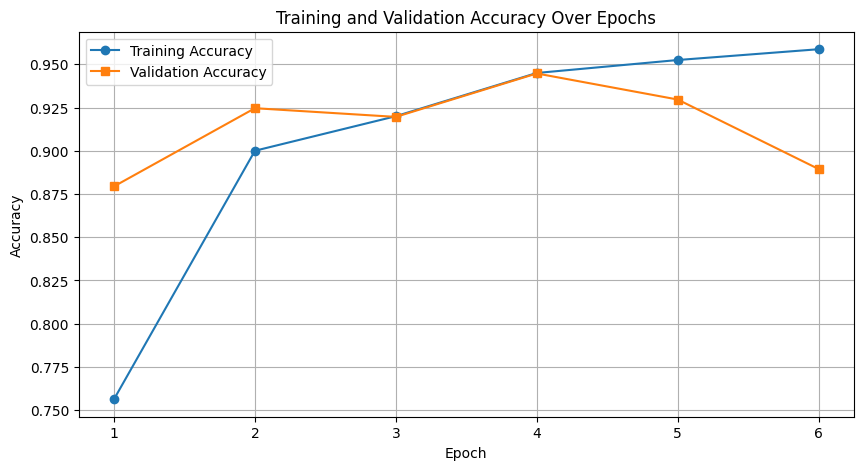

In [ ]:
# Only one training phase
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Save the Model to Google Drive
model.save('/content/drive/My Drive/fire_detection_model.h5')
print("✅ Model saved successfully!")

✅ Model saved successfully!


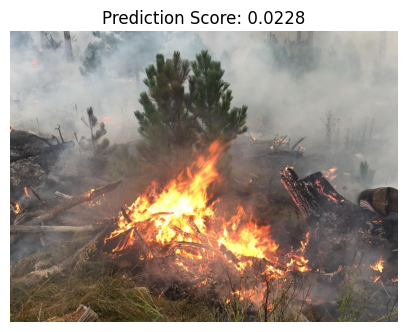

🔥 Fire Detected!



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gc

def predict_fire(image_path, model):
    # Force clear memory before prediction
    gc.collect()

    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Could not load image. Check the path.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (128, 128))
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Predict
    prediction = model.predict(img_input, verbose=0)[0][0]

    # Display
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Prediction Score: {prediction:.4f}")
    plt.axis('off')
    plt.show()

    # Decision threshold
    if prediction < 0.3:
        print("🔥 Fire Detected!")
    else:
        print("✅ No Fire Detected.")

# Example usage
image_path = "/content/drive/MyDrive/firedetect/fire_images/fire.115.png"  # Replace with your image path
predict_fire(image_path, model)
print()